# Melanoma classifier

* Written for the Manning Live Project - [Semi supervised deep learning with gans for melanoma detection](https://liveproject.manning.com/project/146/29/semi-supervised-deep-learning-with-gans-for-melanoma-detection?)
* Semi-supervised generative adversarial network to classify whether a mole is a malignant or benign
* Based on a number of sources including [GANS in Action - Chapter 7](https://livebook.manning.com/book/gans-in-action), [PyTorch DCGan Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) and [Semi-Supervised Learning with GANs: A Tale of Cats and Dogs](https://blog.scaleway.com/semi-supervised/)
* To read more about the project see [here](https://www.bowyer.info/machinelearning-detect-melanoma)


The notebook contains a model that can be run in one of three modes:
* As a supervised melanoma detector based on a deep convolutional neural network ('CNN'). In this mode the model uses the labelled training and validation data. The model can classify moles asa malignant or benign.
* As a deep convolutional generative adversarial network ('DCGAN'). In this mode the model uses unlabelled training data. Given a sample from a multi-variate random distribution, the model will generate an artificial image of a mole.
* As a semi-supervised generative adversarial network ('SGAN'). The model uses both the labelled and unlabelled data. If it capable of generating artificial images of moles, although this is not its primary purposes and will have been somewhat compromised in the images it generates. Its purpose is to classifiy moles with the goal of using hte unlabelled data to produce more accurate classifications than the CNN.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
from PIL import Image
import random
import re
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torchvision import transforms
from torchvision.utils import save_image


dataset_path = "../Datasets/MelanomaDetection/"
train_dataset_path = dataset_path + "labeled"
test_dataset_path = dataset_path + "test"
unlabeled_dataset_path = dataset_path + "unlabeled"


z_dims = 20
image_size = 32 * 32


def set_seeds():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(12321)


def weights_init(model):
    # Specific initialisation of weights needed for Conv, Conv transpose
    # and BatchNorm layers
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Dataloading code

In [3]:
def array_to_dictionary(array):
    return {k: v for k, v in enumerate(array)}


def extract_label(s):
    if re.findall(".*_1.jpg", s):
        return 1
    elif re.findall(".*_0.jpg", s):
        return 0
    else:
        raise RuntimeError("Invalid filename format: " + s)


class MelanomaDataset(Dataset):
    """Unlabelled Melanoma datasets"""

    def __init__(self, label_extractor, dir_path, transform=None):
        self.label_extractor = label_extractor
        self.dir_path = dir_path
        self.transform = transform
        file_list = filter(lambda e: e != ".DS_Store", os.listdir(dir_path))
        self.file_list = array_to_dictionary(file_list)
        self.len = len(self.file_list)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        if index >= self.len:
            raise IndexError
        else:
            img_name = self.file_list[index]
            full_img_name = os.path.join(self.dir_path, img_name)
            image = Image.open(full_img_name)

            if self.transform:
                image = self.transform(image)

            result = {'name': img_name,
                      'image': image}

            if self.label_extractor:
                result['label'] = self.label_extractor(img_name)

            return result


def get_splits(dataset, percentage_train):
    len_train_set = len(dataset)
    train_set = int(len_train_set*percentage_train)
    val_set = len_train_set - train_set
    return train_set, val_set


def data_loader(batch_size, train_transform, test_transform):
    train_dataset = MelanomaDataset(extract_label, train_dataset_path, transform=train_transform)
    train_set_len, val_set_len = get_splits(train_dataset, 0.7)
    train_dataset, val_dataset = data.random_split(train_dataset, [train_set_len, val_set_len])
    test_dataset = MelanomaDataset(extract_label, test_dataset_path, transform=test_transform)
    unlabeled_dataset = MelanomaDataset(None, unlabeled_dataset_path, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, unlabeled_loader, val_loader, test_loader


def batch_random_noise(batch_size):
    return torch.randn(batch_size, z_dims, 1, 1)


def augmentation_transforms():
    rotation = transforms.RandomChoice(
        [transforms.RandomRotation([-3, 3]),
         transforms.RandomRotation([87, 93]),
         transforms.RandomRotation([177, 183]),
         transforms.RandomRotation([267, 273])])

    return transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               rotation])

## The generator model

In [4]:
def create_generator_model():
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            # z_dims x 1 x 1
            self.cvt1 = nn.ConvTranspose2d(z_dims, 64 * 8, 4, 1, 0, bias=False)
            self.bn1 = nn.BatchNorm2d(64 * 8)
            self.reLU1 = nn.ReLU(True)
            # 512 x (4 x 4)
            self.cvt2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
            self.bn2 = nn.BatchNorm2d(64 * 4)
            self.reLU2 = nn.ReLU(True)
            # 256 x (8 x 8)
            self.cvt3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
            self.bn3 = nn.BatchNorm2d(64 * 2)
            self.reLU3 = nn.ReLU(True)
            # 128 x (16 x 16)
            self.cvt4 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)
            # 3 x (32 x 32)

        def forward(self, x):
            x = self.cvt1(x)
            x = self.bn1(x)
            x = self.reLU1(x)
            x = self.cvt2(x)
            x = self.bn2(x)
            x = self.reLU2(x)
            x = self.cvt3(x)
            x = self.bn3(x)
            x = self.reLU3(x)
            x = self.cvt4(x)
            # x = torch.tanh(x)
            x = torch.sigmoid(x)
            return x

    return Generator()

## The discriminiator model

In [5]:
def create_discriminator_model():
    # Neuron 0 means negative and real
    # Neuron 1 means positive and real

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            # 3 x (32 x 32)
            self.cnv1 = nn.Conv2d(3, 64, 4, 1, 2, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.reLU1 = nn.LeakyReLU(0.2, inplace=True)
            # 64 x (33 x 33)
            self.cnv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
            self.bn2 = nn.BatchNorm2d(128)
            self.reLU2 = nn.LeakyReLU(0.2, inplace=True)
            # 128 x (16 x 16)
            self.cnv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
            self.bn3 = nn.BatchNorm2d(256)
            self.reLU3 = nn.LeakyReLU(0.2, inplace=True)
            # 256 x (8 x 8)
            self.cnv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
            self.bn4 = nn.BatchNorm2d(512)
            self.reLU4 = nn.LeakyReLU(0.2, inplace=True)
            # 512 x (4 x 4)
            self.output_neurons = nn.Conv2d(512, 2, 4, 1, 0)

        def forward(self, x):
            x = self.cnv1(x)
            x = self.bn1(x)
            x = self.reLU1(x)
            x = self.cnv2(x)
            x = self.bn2(x)
            x = self.reLU2(x)
            x = self.cnv3(x)
            x = self.bn3(x)
            x = self.reLU3(x)
            x = self.cnv4(x)
            x = self.bn4(x)
            x = self.reLU4(x)
            x = self.output_neurons(x)
            x = x.flatten(1, -1)
            return x

    return Model()

## Image renderer

In [24]:
def view_images(epoch, generator, sample):
    with torch.no_grad():
        # obtain one batch of test images
        gen_image = generator(sample)
        gen_image = gen_image.view(sample.size(0), 3, 32, 32)

        # plot the first eight input images
        fig, axes = plt.subplots(nrows=1, ncols=8, sharex=True, sharey=True)

        for img, ax in zip(gen_image, axes):
            adj_image = torch.swapaxes(torch.swapaxes(img, 0, 1), 1, 2)

            # Format for imshow - (M, N, 3)
            ax.imshow(adj_image)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
    fig.set_size_inches(np.array(fig.get_size_inches()) * 2) 
    plt.show()

## Accuracy functions

In [7]:
def accuracy_fn_labeled(output, wanted):
    with torch.no_grad():
        predicted = torch.argmax(output.data, 1)
        total = output.size(0)
        correct = (predicted == wanted).sum().item()
        return correct / total


def accuracy_fn_fake(output, want_real):
    # Determine if there is at least a 50% chance that
    # these are real moles (or at least a 50% chance that they are fake)
    with torch.no_grad():
        t = torch.exp(torch.logsumexp(output, dim=1))
        probability = t / (t+1) if want_real else 1 / (t+1)
        predicted = probability.numpy() > 0.5
        total = output.size(0)
        correct = predicted.sum().item()
        return correct / total

def model_accuracy(discriminator, a_data_loader, accuracy):
    with torch.no_grad():
        running_accuracy = 0
        for some_data in a_data_loader:
            images, labels = itemgetter('image', 'label')(some_data)
            output = discriminator(images)
            acc = accuracy(output, labels)
            running_accuracy += acc

    return running_accuracy / len(a_data_loader)

## Loss functions

In [8]:
def real_loss(output):
    lse = torch.logsumexp(output, dim=1)
    lse_plus_one = torch.log(torch.exp(lse) + 1)
    return (-lse + lse_plus_one).mean()


def fake_loss(output):
    lse = torch.logsumexp(output, dim=1)
    lse_plus_one = torch.log(torch.exp(lse) + 1)
    return lse_plus_one.mean()

## Training loop

In [22]:
def train(sample, epochs, train_loader, unlabeled_loader, val_loader, test_loader,
          generator_optimizer, discriminator_optimizer,
          generator, discriminator, train_discriminator, batches_per_epoch):
    print("Batches per epoc: ", batches_per_epoch)

    discriminator.train()
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCELoss()

    if generator is not None:
        generator.train()

    # Don't use eval for discriminator when training the generator - and Batch Normalisation
    # It is a complete disaster.
    # Instead keep the discriminator in training mode
    total_count = 0
    unlabeled_loader_iter = None

    for epoch in range(epochs):
        print("\nEpoch: ", epoch)
        running_accuracy = 0
        running_dreal_accuracy = 0

        for index in range(batches_per_epoch):
            # Load batches
            if (total_count % len(unlabeled_loader)) == 0:
                unlabeled_loader_iter = iter(unlabeled_loader)

            unlabeled_images = unlabeled_loader_iter.next()['image']

            if (total_count % len(train_loader)) == 0:
                labeled_loader_iter = iter(train_loader)

            labeled_data = labeled_loader_iter.next()
            images, labels = itemgetter('image', 'label')(labeled_data)

            # Train discriminator - labeled batch
            if train_discriminator:
                discriminator_optimizer.zero_grad()
                output = discriminator(images)

                loss = criterion(output, labels)

                labeled_accuracy = accuracy_fn_labeled(output, labels)
                running_accuracy += labeled_accuracy
                loss.backward()
                discriminator_optimizer.step()

                print('Epoch: %d, Iteration: %i, Labelled Loss: %.3f' %
                      (epoch, index, loss.item()))

            # Train discriminator - unlabeled batch
            if generator is not None:
                unlabeled_batch_size = unlabeled_images.size(0)

                # Train discriminator - real batch
                # Discriminator must mark the real images 1 and the fake images 0
                discriminator_optimizer.zero_grad()
                output_real = discriminator(unlabeled_images)
                loss_real = real_loss(output_real)
                d_real_accuracy = accuracy_fn_fake(output_real, want_real=True)
                running_dreal_accuracy += d_real_accuracy
                loss_real.backward()

                # Train discriminator - fake batch
                random_noise = batch_random_noise(unlabeled_batch_size)
                fake_images = generator(random_noise)
                output_fake_1 = discriminator(fake_images.detach())
                loss_fake = fake_loss(output_fake_1)
                d_loss_accuracy = accuracy_fn_fake(output_fake_1, want_real=False)
                loss_fake.backward()
                discriminator_optimizer.step()

                # Train generator
                generator_optimizer.zero_grad()
                output_fake_2 = discriminator(fake_images)

                # Generator must cause the discriminator to mark the fake images as real
                # ie to fool the discriminator
                generator_loss = real_loss(output_fake_2)
                gen_accuracy = accuracy_fn_fake(output_fake_2, want_real=True)
                generator_loss.backward()
                generator_optimizer.step()

                generator_total_loss = generator_loss.item()
                discriminator_loss_real = loss_real.item()
                discriminator_loss_fake = loss_fake.item()

                print('Epoch: %d, Iteration: %i, Gen Loss: %.3f, Gen Accuracy: %.3f, '
                      'DReal loss: %.3f, DReal accuracy: %.3f, '
                      'DFake loss: %.3f, DFake accuracy: %.3f' %
                      (epoch, index, generator_total_loss, gen_accuracy,
                       discriminator_loss_real, d_real_accuracy,
                       discriminator_loss_fake, d_loss_accuracy))

                if (total_count % 20) == 0:
                    view_images(epoch, generator, sample)

            total_count += 1
        running_accuracy /= batches_per_epoch
        running_dreal_accuracy /= batches_per_epoch
        validation_accuracy = model_accuracy(discriminator, val_loader, accuracy_fn_labeled)

        if generator is not None:
            print("End of epoc")
            print("Training accuracy in spotting fakes for epoc: ", running_dreal_accuracy)
        
        if train_discriminator:
            print("Training accuracy in discriminating malignant/benign for epoc: ", running_accuracy)
            print("Validation accuracy in discriminating malignant/benign for epoc: ", validation_accuracy)
            test_accuracy = model_accuracy(discriminator, test_loader, accuracy_fn_labeled)
            print("Test accuracy in discriminating malignant/benign: ", test_accuracy)

            
def run_model(mode):
    # Mode = 0 then CNN
    # Mode = 1 then DCGAN
    # Mode = 2 then SGAN
    
    set_seeds()

    lr = 0.0002
    beta1 = 0.5
    batch_size = 128
    epochs = 5
    sample = batch_random_noise(batch_size)

    base = transforms.ToTensor()
    augmentation = augmentation_transforms()
    preprocess = transforms.Compose([base, augmentation])

    train_loader, unlabeled_loader, val_loader, test_loader \
        = data_loader(batch_size, preprocess, base)

    generator = create_generator_model()
    generator.apply(weights_init)

    discriminator = create_discriminator_model()
    discriminator.apply(weights_init)

    generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    
    if mode == 0:
        train(sample, epochs, train_loader, unlabeled_loader, val_loader, test_loader,
              generator_optimizer, discriminator_optimizer,
              None, discriminator, train_discriminator=True, batches_per_epoch=len(test_loader))
    elif mode == 1:    
        train(sample, epochs, train_loader, unlabeled_loader, val_loader, test_loader,
              generator_optimizer, discriminator_optimizer,
              generator, discriminator, train_discriminator=False, batches_per_epoch=len(unlabeled_loader))     
        view_images(epochs, generator, sample)
    elif mode == 2:    
        train(sample, epochs, train_loader, unlabeled_loader, val_loader, test_loader,
              generator_optimizer, discriminator_optimizer,
              generator, discriminator, train_discriminator=True, batches_per_epoch=len(unlabeled_loader))

## Run model as supervised CNN

* This gives us a baseline accuracy for the model using just the labelled data

In [15]:
run_model(0)

Batches per epoc:  5

Epoch:  0
Epoch: 0, Iteration: 0, Labelled Loss: 1.164
Epoch: 0, Iteration: 1, Labelled Loss: 5.088
Epoch: 0, Iteration: 2, Labelled Loss: 2.129
Epoch: 0, Iteration: 3, Labelled Loss: 2.909
Epoch: 0, Iteration: 4, Labelled Loss: 1.885
Training accuracy in discriminating malignant/benign for epoc:  0.5916666666666667
Validation accuracy in discriminating malignant/benign for epoc:  0.65
Test accuracy in discriminating malignant/benign:  0.6670454545454545

Epoch:  1
Epoch: 1, Iteration: 0, Labelled Loss: 0.676
Epoch: 1, Iteration: 1, Labelled Loss: 1.160
Epoch: 1, Iteration: 2, Labelled Loss: 0.940
Epoch: 1, Iteration: 3, Labelled Loss: 0.689
Epoch: 1, Iteration: 4, Labelled Loss: 0.684
Training accuracy in discriminating malignant/benign for epoc:  0.7854166666666667
Validation accuracy in discriminating malignant/benign for epoc:  0.65
Test accuracy in discriminating malignant/benign:  0.6338068181818182

Epoch:  2
Epoch: 2, Iteration: 0, Labelled Loss: 1.133
Epo

Selecting the number of epochs to maximize the validation accuracy, gives a test accuracy of around 71%. Unfortunately with so little data, the validation set is only 40 images to this figure moves around a lot.

## Run model as DCGAN

Now the run is as a DCGAN whose goal is to generate images that look like mole. This enables verification that the generator and discriminator are working together correctly.

Batches per epoc:  55

Epoch:  0
Epoch: 0, Iteration: 0, Gen Loss: 7.811, Gen Accuracy: 0.000, DReal loss: 0.268, DReal accuracy: 0.977, DFake loss: 1.434, DFake accuracy: 0.055


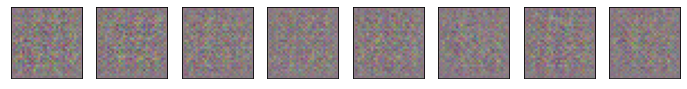

Epoch: 0, Iteration: 1, Gen Loss: 0.532, Gen Accuracy: 0.766, DReal loss: 1.491, DReal accuracy: 0.188, DFake loss: 0.039, DFake accuracy: 1.000
Epoch: 0, Iteration: 2, Gen Loss: 5.564, Gen Accuracy: 0.000, DReal loss: 0.031, DReal accuracy: 0.992, DFake loss: 4.343, DFake accuracy: 0.000
Epoch: 0, Iteration: 3, Gen Loss: 8.130, Gen Accuracy: 0.000, DReal loss: 0.083, DReal accuracy: 0.977, DFake loss: 0.198, DFake accuracy: 0.961
Epoch: 0, Iteration: 4, Gen Loss: 6.409, Gen Accuracy: 0.000, DReal loss: 0.336, DReal accuracy: 0.836, DFake loss: 0.010, DFake accuracy: 1.000
Epoch: 0, Iteration: 5, Gen Loss: 3.948, Gen Accuracy: 0.000, DReal loss: 0.300, DReal accuracy: 0.891, DFake loss: 0.045, DFake accuracy: 1.000
Epoch: 0, Iteration: 6, Gen Loss: 5.581, Gen Accuracy: 0.000, DReal loss: 0.137, DReal accuracy: 0.914, DFake loss: 0.549, DFake accuracy: 0.789
Epoch: 0, Iteration: 7, Gen Loss: 7.736, Gen Accuracy: 0.000, DReal loss: 0.100, DReal accuracy: 0.977, DFake loss: 0.216, DFake a

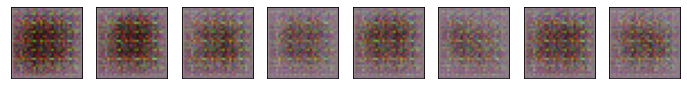

Epoch: 0, Iteration: 21, Gen Loss: 10.008, Gen Accuracy: 0.000, DReal loss: 0.101, DReal accuracy: 0.969, DFake loss: 0.800, DFake accuracy: 0.602
Epoch: 0, Iteration: 22, Gen Loss: 6.131, Gen Accuracy: 0.000, DReal loss: 1.471, DReal accuracy: 0.531, DFake loss: 0.001, DFake accuracy: 1.000
Epoch: 0, Iteration: 23, Gen Loss: 4.571, Gen Accuracy: 0.031, DReal loss: 0.064, DReal accuracy: 0.984, DFake loss: 0.085, DFake accuracy: 0.992
Epoch: 0, Iteration: 24, Gen Loss: 8.243, Gen Accuracy: 0.000, DReal loss: 0.006, DReal accuracy: 1.000, DFake loss: 0.408, DFake accuracy: 0.836
Epoch: 0, Iteration: 25, Gen Loss: 8.791, Gen Accuracy: 0.000, DReal loss: 0.023, DReal accuracy: 1.000, DFake loss: 0.006, DFake accuracy: 1.000
Epoch: 0, Iteration: 26, Gen Loss: 7.088, Gen Accuracy: 0.000, DReal loss: 0.088, DReal accuracy: 0.961, DFake loss: 0.004, DFake accuracy: 1.000
Epoch: 0, Iteration: 27, Gen Loss: 5.429, Gen Accuracy: 0.000, DReal loss: 0.013, DReal accuracy: 1.000, DFake loss: 0.043,

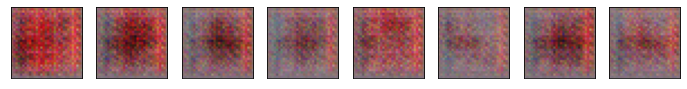

Epoch: 0, Iteration: 41, Gen Loss: 9.105, Gen Accuracy: 0.000, DReal loss: 0.003, DReal accuracy: 1.000, DFake loss: 3.695, DFake accuracy: 0.094
Epoch: 0, Iteration: 42, Gen Loss: 7.913, Gen Accuracy: 0.000, DReal loss: 0.490, DReal accuracy: 0.758, DFake loss: 0.009, DFake accuracy: 1.000
Epoch: 0, Iteration: 43, Gen Loss: 6.158, Gen Accuracy: 0.000, DReal loss: 0.149, DReal accuracy: 0.961, DFake loss: 0.032, DFake accuracy: 1.000
Epoch: 0, Iteration: 44, Gen Loss: 5.420, Gen Accuracy: 0.000, DReal loss: 0.022, DReal accuracy: 1.000, DFake loss: 0.128, DFake accuracy: 0.953
Epoch: 0, Iteration: 45, Gen Loss: 6.218, Gen Accuracy: 0.000, DReal loss: 0.014, DReal accuracy: 1.000, DFake loss: 0.233, DFake accuracy: 0.938
Epoch: 0, Iteration: 46, Gen Loss: 5.175, Gen Accuracy: 0.000, DReal loss: 0.265, DReal accuracy: 0.930, DFake loss: 0.112, DFake accuracy: 0.992
Epoch: 0, Iteration: 47, Gen Loss: 6.888, Gen Accuracy: 0.000, DReal loss: 0.146, DReal accuracy: 0.945, DFake loss: 0.417, 

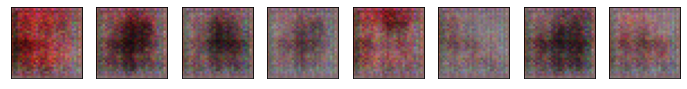

Epoch: 1, Iteration: 6, Gen Loss: 6.364, Gen Accuracy: 0.000, DReal loss: 0.058, DReal accuracy: 0.992, DFake loss: 0.584, DFake accuracy: 0.781
Epoch: 1, Iteration: 7, Gen Loss: 5.924, Gen Accuracy: 0.000, DReal loss: 0.295, DReal accuracy: 0.859, DFake loss: 0.152, DFake accuracy: 0.945
Epoch: 1, Iteration: 8, Gen Loss: 6.903, Gen Accuracy: 0.000, DReal loss: 0.125, DReal accuracy: 0.961, DFake loss: 0.262, DFake accuracy: 0.875
Epoch: 1, Iteration: 9, Gen Loss: 4.099, Gen Accuracy: 0.008, DReal loss: 0.362, DReal accuracy: 0.852, DFake loss: 0.095, DFake accuracy: 0.969
Epoch: 1, Iteration: 10, Gen Loss: 12.400, Gen Accuracy: 0.000, DReal loss: 0.020, DReal accuracy: 1.000, DFake loss: 0.849, DFake accuracy: 0.516
Epoch: 1, Iteration: 11, Gen Loss: 1.286, Gen Accuracy: 0.359, DReal loss: 4.602, DReal accuracy: 0.039, DFake loss: 0.000, DFake accuracy: 1.000
Epoch: 1, Iteration: 12, Gen Loss: 8.821, Gen Accuracy: 0.000, DReal loss: 0.001, DReal accuracy: 1.000, DFake loss: 2.033, DFa

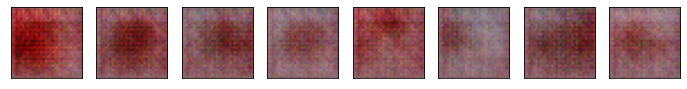

Epoch: 1, Iteration: 26, Gen Loss: 3.343, Gen Accuracy: 0.000, DReal loss: 0.295, DReal accuracy: 0.875, DFake loss: 0.248, DFake accuracy: 0.977
Epoch: 1, Iteration: 27, Gen Loss: 5.754, Gen Accuracy: 0.000, DReal loss: 0.136, DReal accuracy: 0.977, DFake loss: 0.377, DFake accuracy: 0.875
Epoch: 1, Iteration: 28, Gen Loss: 1.113, Gen Accuracy: 0.148, DReal loss: 0.672, DReal accuracy: 0.656, DFake loss: 0.028, DFake accuracy: 1.000
Epoch: 1, Iteration: 29, Gen Loss: 10.395, Gen Accuracy: 0.000, DReal loss: 0.006, DReal accuracy: 1.000, DFake loss: 1.509, DFake accuracy: 0.102
Epoch: 1, Iteration: 30, Gen Loss: 2.099, Gen Accuracy: 0.023, DReal loss: 2.910, DReal accuracy: 0.070, DFake loss: 0.001, DFake accuracy: 1.000
Epoch: 1, Iteration: 31, Gen Loss: 3.899, Gen Accuracy: 0.000, DReal loss: 0.014, DReal accuracy: 1.000, DFake loss: 0.722, DFake accuracy: 0.633
Epoch: 1, Iteration: 32, Gen Loss: 5.912, Gen Accuracy: 0.000, DReal loss: 0.066, DReal accuracy: 0.984, DFake loss: 0.288,

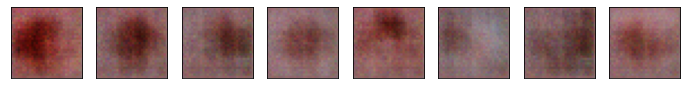

Epoch: 1, Iteration: 46, Gen Loss: 3.415, Gen Accuracy: 0.000, DReal loss: 0.208, DReal accuracy: 0.945, DFake loss: 0.224, DFake accuracy: 0.961
Epoch: 1, Iteration: 47, Gen Loss: 2.020, Gen Accuracy: 0.000, DReal loss: 0.343, DReal accuracy: 0.883, DFake loss: 0.184, DFake accuracy: 0.984
Epoch: 1, Iteration: 48, Gen Loss: 4.383, Gen Accuracy: 0.000, DReal loss: 0.191, DReal accuracy: 0.953, DFake loss: 0.395, DFake accuracy: 0.852
Epoch: 1, Iteration: 49, Gen Loss: 0.165, Gen Accuracy: 0.969, DReal loss: 1.059, DReal accuracy: 0.336, DFake loss: 0.080, DFake accuracy: 1.000
Epoch: 1, Iteration: 50, Gen Loss: 8.672, Gen Accuracy: 0.000, DReal loss: 0.006, DReal accuracy: 1.000, DFake loss: 2.644, DFake accuracy: 0.031
Epoch: 1, Iteration: 51, Gen Loss: 2.122, Gen Accuracy: 0.062, DReal loss: 3.126, DReal accuracy: 0.031, DFake loss: 0.004, DFake accuracy: 1.000
Epoch: 1, Iteration: 52, Gen Loss: 3.279, Gen Accuracy: 0.008, DReal loss: 0.079, DReal accuracy: 0.992, DFake loss: 0.679, 

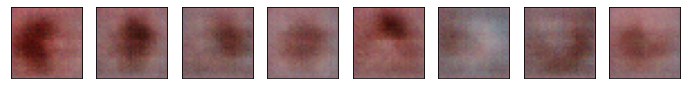

Epoch: 2, Iteration: 11, Gen Loss: 2.276, Gen Accuracy: 0.008, DReal loss: 0.188, DReal accuracy: 0.977, DFake loss: 0.254, DFake accuracy: 0.977
Epoch: 2, Iteration: 12, Gen Loss: 3.142, Gen Accuracy: 0.000, DReal loss: 0.147, DReal accuracy: 0.977, DFake loss: 0.272, DFake accuracy: 0.914
Epoch: 2, Iteration: 13, Gen Loss: 1.943, Gen Accuracy: 0.023, DReal loss: 0.394, DReal accuracy: 0.898, DFake loss: 0.167, DFake accuracy: 0.977
Epoch: 2, Iteration: 14, Gen Loss: 2.909, Gen Accuracy: 0.000, DReal loss: 0.174, DReal accuracy: 0.969, DFake loss: 0.362, DFake accuracy: 0.906
Epoch: 2, Iteration: 15, Gen Loss: 1.974, Gen Accuracy: 0.000, DReal loss: 0.448, DReal accuracy: 0.852, DFake loss: 0.279, DFake accuracy: 0.984
Epoch: 2, Iteration: 16, Gen Loss: 2.699, Gen Accuracy: 0.000, DReal loss: 0.189, DReal accuracy: 0.977, DFake loss: 0.248, DFake accuracy: 0.969
Epoch: 2, Iteration: 17, Gen Loss: 1.843, Gen Accuracy: 0.008, DReal loss: 0.305, DReal accuracy: 0.945, DFake loss: 0.182, 

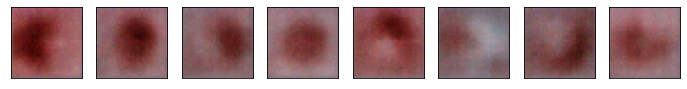

Epoch: 2, Iteration: 31, Gen Loss: 2.544, Gen Accuracy: 0.016, DReal loss: 0.189, DReal accuracy: 0.977, DFake loss: 0.206, DFake accuracy: 0.977
Epoch: 2, Iteration: 32, Gen Loss: 0.934, Gen Accuracy: 0.383, DReal loss: 0.431, DReal accuracy: 0.852, DFake loss: 0.119, DFake accuracy: 1.000
Epoch: 2, Iteration: 33, Gen Loss: 6.209, Gen Accuracy: 0.000, DReal loss: 0.030, DReal accuracy: 1.000, DFake loss: 1.068, DFake accuracy: 0.328
Epoch: 2, Iteration: 34, Gen Loss: 0.404, Gen Accuracy: 0.852, DReal loss: 2.347, DReal accuracy: 0.062, DFake loss: 0.012, DFake accuracy: 1.000
Epoch: 2, Iteration: 35, Gen Loss: 3.833, Gen Accuracy: 0.000, DReal loss: 0.018, DReal accuracy: 1.000, DFake loss: 1.282, DFake accuracy: 0.203
Epoch: 2, Iteration: 36, Gen Loss: 1.845, Gen Accuracy: 0.062, DReal loss: 0.645, DReal accuracy: 0.602, DFake loss: 0.143, DFake accuracy: 0.984
Epoch: 2, Iteration: 37, Gen Loss: 1.604, Gen Accuracy: 0.141, DReal loss: 0.291, DReal accuracy: 0.867, DFake loss: 0.268, 

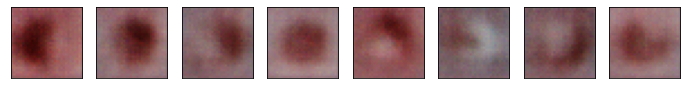

Epoch: 2, Iteration: 51, Gen Loss: 1.679, Gen Accuracy: 0.281, DReal loss: 0.538, DReal accuracy: 0.711, DFake loss: 0.252, DFake accuracy: 0.914
Epoch: 2, Iteration: 52, Gen Loss: 4.036, Gen Accuracy: 0.000, DReal loss: 0.244, DReal accuracy: 0.938, DFake loss: 0.736, DFake accuracy: 0.664
Epoch: 2, Iteration: 53, Gen Loss: 1.060, Gen Accuracy: 0.281, DReal loss: 0.977, DReal accuracy: 0.516, DFake loss: 0.135, DFake accuracy: 0.977
Epoch: 2, Iteration: 54, Gen Loss: 5.571, Gen Accuracy: 0.000, DReal loss: 0.065, DReal accuracy: 0.991, DFake loss: 1.013, DFake accuracy: 0.330
End of epoc
Training accuracy in spotting fakes for epoc:  0.8167318825042881

Epoch:  3
Epoch: 3, Iteration: 0, Gen Loss: 1.716, Gen Accuracy: 0.305, DReal loss: 1.087, DReal accuracy: 0.281, DFake loss: 0.010, DFake accuracy: 1.000
Epoch: 3, Iteration: 1, Gen Loss: 3.069, Gen Accuracy: 0.008, DReal loss: 0.055, DReal accuracy: 1.000, DFake loss: 1.002, DFake accuracy: 0.500
Epoch: 3, Iteration: 2, Gen Loss: 3.4

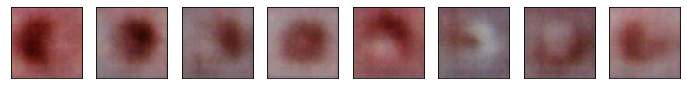

Epoch: 3, Iteration: 16, Gen Loss: 6.452, Gen Accuracy: 0.000, DReal loss: 0.032, DReal accuracy: 1.000, DFake loss: 0.555, DFake accuracy: 0.742
Epoch: 3, Iteration: 17, Gen Loss: 0.039, Gen Accuracy: 1.000, DReal loss: 2.370, DReal accuracy: 0.023, DFake loss: 0.004, DFake accuracy: 1.000
Epoch: 3, Iteration: 18, Gen Loss: 5.661, Gen Accuracy: 0.000, DReal loss: 0.001, DReal accuracy: 1.000, DFake loss: 3.373, DFake accuracy: 0.000
Epoch: 3, Iteration: 19, Gen Loss: 1.129, Gen Accuracy: 0.312, DReal loss: 1.716, DReal accuracy: 0.281, DFake loss: 0.031, DFake accuracy: 1.000
Epoch: 3, Iteration: 20, Gen Loss: 2.936, Gen Accuracy: 0.000, DReal loss: 0.101, DReal accuracy: 0.977, DFake loss: 0.931, DFake accuracy: 0.492
Epoch: 3, Iteration: 21, Gen Loss: 2.477, Gen Accuracy: 0.000, DReal loss: 0.360, DReal accuracy: 0.898, DFake loss: 0.166, DFake accuracy: 0.992
Epoch: 3, Iteration: 22, Gen Loss: 1.086, Gen Accuracy: 0.258, DReal loss: 0.465, DReal accuracy: 0.797, DFake loss: 0.228, 

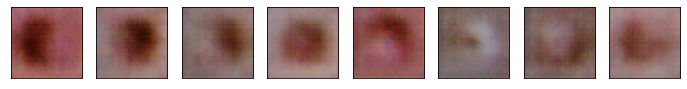

Epoch: 3, Iteration: 36, Gen Loss: 2.400, Gen Accuracy: 0.000, DReal loss: 0.191, DReal accuracy: 0.969, DFake loss: 0.276, DFake accuracy: 0.969
Epoch: 3, Iteration: 37, Gen Loss: 4.933, Gen Accuracy: 0.000, DReal loss: 0.311, DReal accuracy: 0.930, DFake loss: 0.755, DFake accuracy: 0.484
Epoch: 3, Iteration: 38, Gen Loss: 0.056, Gen Accuracy: 1.000, DReal loss: 2.314, DReal accuracy: 0.031, DFake loss: 0.096, DFake accuracy: 1.000
Epoch: 3, Iteration: 39, Gen Loss: 7.077, Gen Accuracy: 0.000, DReal loss: 0.010, DReal accuracy: 1.000, DFake loss: 3.629, DFake accuracy: 0.000
Epoch: 3, Iteration: 40, Gen Loss: 2.341, Gen Accuracy: 0.008, DReal loss: 2.010, DReal accuracy: 0.055, DFake loss: 0.016, DFake accuracy: 1.000
Epoch: 3, Iteration: 41, Gen Loss: 2.492, Gen Accuracy: 0.000, DReal loss: 0.094, DReal accuracy: 0.992, DFake loss: 0.611, DFake accuracy: 0.625
Epoch: 3, Iteration: 42, Gen Loss: 4.193, Gen Accuracy: 0.000, DReal loss: 0.113, DReal accuracy: 0.984, DFake loss: 0.475, 

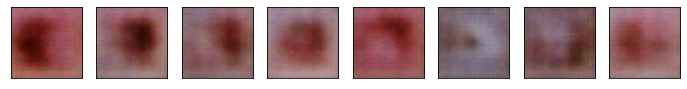

Epoch: 4, Iteration: 1, Gen Loss: 0.312, Gen Accuracy: 0.930, DReal loss: 1.403, DReal accuracy: 0.148, DFake loss: 0.045, DFake accuracy: 1.000
Epoch: 4, Iteration: 2, Gen Loss: 5.335, Gen Accuracy: 0.000, DReal loss: 0.011, DReal accuracy: 1.000, DFake loss: 2.208, DFake accuracy: 0.016
Epoch: 4, Iteration: 3, Gen Loss: 1.365, Gen Accuracy: 0.203, DReal loss: 2.203, DReal accuracy: 0.047, DFake loss: 0.011, DFake accuracy: 1.000
Epoch: 4, Iteration: 4, Gen Loss: 2.720, Gen Accuracy: 0.000, DReal loss: 0.063, DReal accuracy: 1.000, DFake loss: 0.947, DFake accuracy: 0.336
Epoch: 4, Iteration: 5, Gen Loss: 2.492, Gen Accuracy: 0.000, DReal loss: 0.392, DReal accuracy: 0.836, DFake loss: 0.262, DFake accuracy: 0.945
Epoch: 4, Iteration: 6, Gen Loss: 1.287, Gen Accuracy: 0.172, DReal loss: 0.608, DReal accuracy: 0.688, DFake loss: 0.176, DFake accuracy: 1.000
Epoch: 4, Iteration: 7, Gen Loss: 2.546, Gen Accuracy: 0.000, DReal loss: 0.209, DReal accuracy: 0.969, DFake loss: 0.801, DFake a

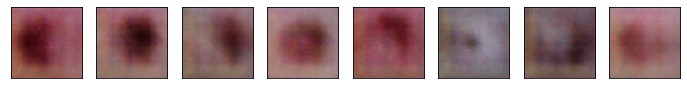

Epoch: 4, Iteration: 21, Gen Loss: 1.841, Gen Accuracy: 0.016, DReal loss: 0.535, DReal accuracy: 0.719, DFake loss: 0.352, DFake accuracy: 0.945
Epoch: 4, Iteration: 22, Gen Loss: 4.735, Gen Accuracy: 0.000, DReal loss: 0.198, DReal accuracy: 0.953, DFake loss: 0.680, DFake accuracy: 0.531
Epoch: 4, Iteration: 23, Gen Loss: 0.472, Gen Accuracy: 0.828, DReal loss: 1.326, DReal accuracy: 0.211, DFake loss: 0.024, DFake accuracy: 1.000
Epoch: 4, Iteration: 24, Gen Loss: 6.152, Gen Accuracy: 0.000, DReal loss: 0.024, DReal accuracy: 1.000, DFake loss: 1.858, DFake accuracy: 0.016
Epoch: 4, Iteration: 25, Gen Loss: 1.017, Gen Accuracy: 0.312, DReal loss: 2.234, DReal accuracy: 0.031, DFake loss: 0.007, DFake accuracy: 1.000
Epoch: 4, Iteration: 26, Gen Loss: 4.525, Gen Accuracy: 0.000, DReal loss: 0.016, DReal accuracy: 1.000, DFake loss: 1.455, DFake accuracy: 0.117
Epoch: 4, Iteration: 27, Gen Loss: 2.263, Gen Accuracy: 0.000, DReal loss: 0.685, DReal accuracy: 0.570, DFake loss: 0.074, 

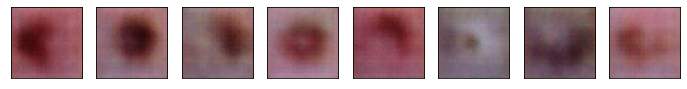

Epoch: 4, Iteration: 41, Gen Loss: 3.493, Gen Accuracy: 0.000, DReal loss: 0.223, DReal accuracy: 0.961, DFake loss: 0.329, DFake accuracy: 0.961
Epoch: 4, Iteration: 42, Gen Loss: 1.676, Gen Accuracy: 0.039, DReal loss: 0.588, DReal accuracy: 0.719, DFake loss: 0.145, DFake accuracy: 1.000
Epoch: 4, Iteration: 43, Gen Loss: 3.542, Gen Accuracy: 0.000, DReal loss: 0.123, DReal accuracy: 0.992, DFake loss: 0.717, DFake accuracy: 0.625
Epoch: 4, Iteration: 44, Gen Loss: 1.246, Gen Accuracy: 0.148, DReal loss: 0.836, DReal accuracy: 0.500, DFake loss: 0.079, DFake accuracy: 1.000
Epoch: 4, Iteration: 45, Gen Loss: 4.137, Gen Accuracy: 0.000, DReal loss: 0.119, DReal accuracy: 1.000, DFake loss: 1.074, DFake accuracy: 0.219
Epoch: 4, Iteration: 46, Gen Loss: 0.950, Gen Accuracy: 0.375, DReal loss: 1.182, DReal accuracy: 0.250, DFake loss: 0.067, DFake accuracy: 1.000
Epoch: 4, Iteration: 47, Gen Loss: 3.685, Gen Accuracy: 0.000, DReal loss: 0.076, DReal accuracy: 1.000, DFake loss: 1.015, 

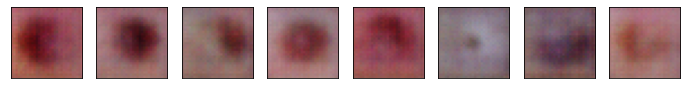

In [25]:
run_model(1)

## Run model as SGAN

* In this mode, the model uses labelled and unlabelled data to produce a more accurate classifier

Batches per epoc:  55

Epoch:  0
Epoch: 0, Iteration: 0, Labelled Loss: 1.164
Epoch: 0, Iteration: 0, Gen Loss: 4.858, Gen Accuracy: 0.000, DReal loss: 0.005, DReal accuracy: 1.000, DFake loss: 5.598, DFake accuracy: 0.000


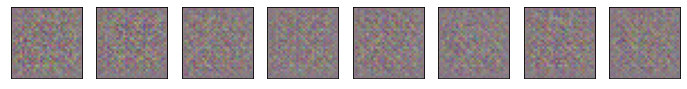

Epoch: 0, Iteration: 1, Labelled Loss: 3.709
Epoch: 0, Iteration: 1, Gen Loss: 1.391, Gen Accuracy: 0.156, DReal loss: 1.215, DReal accuracy: 0.492, DFake loss: 0.036, DFake accuracy: 1.000
Epoch: 0, Iteration: 2, Labelled Loss: 2.050
Epoch: 0, Iteration: 2, Gen Loss: 6.152, Gen Accuracy: 0.000, DReal loss: 0.128, DReal accuracy: 0.938, DFake loss: 3.323, DFake accuracy: 0.000
Epoch: 0, Iteration: 3, Labelled Loss: 0.357
Epoch: 0, Iteration: 3, Gen Loss: 5.054, Gen Accuracy: 0.000, DReal loss: 0.767, DReal accuracy: 0.641, DFake loss: 0.004, DFake accuracy: 1.000
Epoch: 0, Iteration: 4, Labelled Loss: 1.948
Epoch: 0, Iteration: 4, Gen Loss: 5.062, Gen Accuracy: 0.000, DReal loss: 0.211, DReal accuracy: 0.891, DFake loss: 0.293, DFake accuracy: 0.906
Epoch: 0, Iteration: 5, Labelled Loss: 3.065
Epoch: 0, Iteration: 5, Gen Loss: 4.112, Gen Accuracy: 0.000, DReal loss: 0.550, DReal accuracy: 0.758, DFake loss: 0.043, DFake accuracy: 1.000
Epoch: 0, Iteration: 6, Labelled Loss: 0.735
Epoch

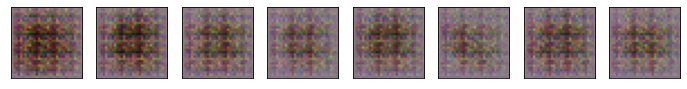

Epoch: 0, Iteration: 21, Labelled Loss: 1.048
Epoch: 0, Iteration: 21, Gen Loss: 5.276, Gen Accuracy: 0.000, DReal loss: 0.067, DReal accuracy: 0.984, DFake loss: 0.436, DFake accuracy: 0.805
Epoch: 0, Iteration: 22, Labelled Loss: 0.869
Epoch: 0, Iteration: 22, Gen Loss: 4.276, Gen Accuracy: 0.000, DReal loss: 0.633, DReal accuracy: 0.734, DFake loss: 0.011, DFake accuracy: 1.000
Epoch: 0, Iteration: 23, Labelled Loss: 1.232
Epoch: 0, Iteration: 23, Gen Loss: 6.132, Gen Accuracy: 0.000, DReal loss: 0.090, DReal accuracy: 0.977, DFake loss: 0.776, DFake accuracy: 0.641
Epoch: 0, Iteration: 24, Labelled Loss: 0.756
Epoch: 0, Iteration: 24, Gen Loss: 3.756, Gen Accuracy: 0.016, DReal loss: 0.723, DReal accuracy: 0.617, DFake loss: 0.006, DFake accuracy: 1.000
Epoch: 0, Iteration: 25, Labelled Loss: 0.423
Epoch: 0, Iteration: 25, Gen Loss: 6.852, Gen Accuracy: 0.000, DReal loss: 0.057, DReal accuracy: 0.992, DFake loss: 1.343, DFake accuracy: 0.445
Epoch: 0, Iteration: 26, Labelled Loss: 

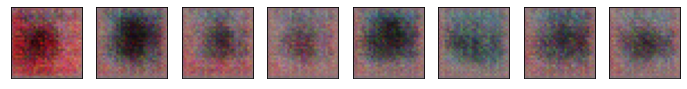

Epoch: 0, Iteration: 41, Labelled Loss: 0.965
Epoch: 0, Iteration: 41, Gen Loss: 3.447, Gen Accuracy: 0.000, DReal loss: 0.046, DReal accuracy: 1.000, DFake loss: 2.363, DFake accuracy: 0.031
Epoch: 0, Iteration: 42, Labelled Loss: 0.750
Epoch: 0, Iteration: 42, Gen Loss: 1.532, Gen Accuracy: 0.133, DReal loss: 1.273, DReal accuracy: 0.430, DFake loss: 0.087, DFake accuracy: 1.000
Epoch: 0, Iteration: 43, Labelled Loss: 0.275
Epoch: 0, Iteration: 43, Gen Loss: 4.285, Gen Accuracy: 0.000, DReal loss: 0.093, DReal accuracy: 0.992, DFake loss: 0.849, DFake accuracy: 0.492
Epoch: 0, Iteration: 44, Labelled Loss: 0.771
Epoch: 0, Iteration: 44, Gen Loss: 2.601, Gen Accuracy: 0.000, DReal loss: 0.854, DReal accuracy: 0.516, DFake loss: 0.042, DFake accuracy: 1.000
Epoch: 0, Iteration: 45, Labelled Loss: 0.159
Epoch: 0, Iteration: 45, Gen Loss: 3.984, Gen Accuracy: 0.000, DReal loss: 0.048, DReal accuracy: 0.992, DFake loss: 0.809, DFake accuracy: 0.500
Epoch: 0, Iteration: 46, Labelled Loss: 

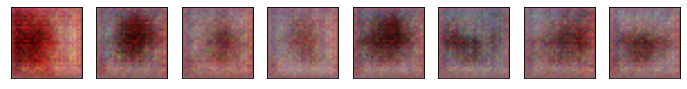

Epoch: 1, Iteration: 6, Labelled Loss: 0.792
Epoch: 1, Iteration: 6, Gen Loss: 2.834, Gen Accuracy: 0.000, DReal loss: 0.132, DReal accuracy: 0.977, DFake loss: 0.401, DFake accuracy: 0.875
Epoch: 1, Iteration: 7, Labelled Loss: 0.473
Epoch: 1, Iteration: 7, Gen Loss: 2.631, Gen Accuracy: 0.008, DReal loss: 0.249, DReal accuracy: 0.898, DFake loss: 0.186, DFake accuracy: 0.961
Epoch: 1, Iteration: 8, Labelled Loss: 0.247
Epoch: 1, Iteration: 8, Gen Loss: 2.475, Gen Accuracy: 0.008, DReal loss: 0.149, DReal accuracy: 0.977, DFake loss: 0.402, DFake accuracy: 0.859
Epoch: 1, Iteration: 9, Labelled Loss: 0.320
Epoch: 1, Iteration: 9, Gen Loss: 2.240, Gen Accuracy: 0.000, DReal loss: 0.399, DReal accuracy: 0.812, DFake loss: 0.120, DFake accuracy: 1.000
Epoch: 1, Iteration: 10, Labelled Loss: 1.556
Epoch: 1, Iteration: 10, Gen Loss: 3.144, Gen Accuracy: 0.000, DReal loss: 0.216, DReal accuracy: 0.961, DFake loss: 0.786, DFake accuracy: 0.641
Epoch: 1, Iteration: 11, Labelled Loss: 1.357
Ep

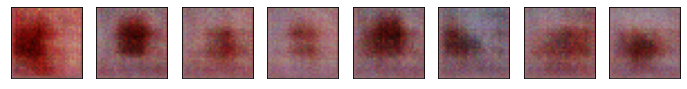

Epoch: 1, Iteration: 26, Labelled Loss: 0.091
Epoch: 1, Iteration: 26, Gen Loss: 2.504, Gen Accuracy: 0.008, DReal loss: 0.078, DReal accuracy: 0.992, DFake loss: 0.516, DFake accuracy: 0.758
Epoch: 1, Iteration: 27, Labelled Loss: 0.323
Epoch: 1, Iteration: 27, Gen Loss: 2.201, Gen Accuracy: 0.000, DReal loss: 0.340, DReal accuracy: 0.852, DFake loss: 0.131, DFake accuracy: 1.000
Epoch: 1, Iteration: 28, Labelled Loss: 0.193
Epoch: 1, Iteration: 28, Gen Loss: 2.562, Gen Accuracy: 0.008, DReal loss: 0.124, DReal accuracy: 0.969, DFake loss: 0.385, DFake accuracy: 0.859
Epoch: 1, Iteration: 29, Labelled Loss: 0.371
Epoch: 1, Iteration: 29, Gen Loss: 1.866, Gen Accuracy: 0.031, DReal loss: 0.425, DReal accuracy: 0.797, DFake loss: 0.126, DFake accuracy: 0.992
Epoch: 1, Iteration: 30, Labelled Loss: 0.257
Epoch: 1, Iteration: 30, Gen Loss: 3.319, Gen Accuracy: 0.000, DReal loss: 0.092, DReal accuracy: 0.984, DFake loss: 0.628, DFake accuracy: 0.688
Epoch: 1, Iteration: 31, Labelled Loss: 

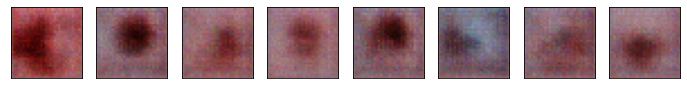

Epoch: 1, Iteration: 46, Labelled Loss: 0.547
Epoch: 1, Iteration: 46, Gen Loss: 1.824, Gen Accuracy: 0.125, DReal loss: 1.798, DReal accuracy: 0.125, DFake loss: 0.031, DFake accuracy: 1.000
Epoch: 1, Iteration: 47, Labelled Loss: 0.508
Epoch: 1, Iteration: 47, Gen Loss: 2.141, Gen Accuracy: 0.008, DReal loss: 0.117, DReal accuracy: 0.969, DFake loss: 1.195, DFake accuracy: 0.320
Epoch: 1, Iteration: 48, Labelled Loss: 0.502
Epoch: 1, Iteration: 48, Gen Loss: 1.679, Gen Accuracy: 0.023, DReal loss: 0.732, DReal accuracy: 0.562, DFake loss: 0.181, DFake accuracy: 0.961
Epoch: 1, Iteration: 49, Labelled Loss: 0.407
Epoch: 1, Iteration: 49, Gen Loss: 2.000, Gen Accuracy: 0.016, DReal loss: 0.197, DReal accuracy: 0.961, DFake loss: 0.595, DFake accuracy: 0.641
Epoch: 1, Iteration: 50, Labelled Loss: 0.297
Epoch: 1, Iteration: 50, Gen Loss: 1.473, Gen Accuracy: 0.078, DReal loss: 0.656, DReal accuracy: 0.625, DFake loss: 0.243, DFake accuracy: 0.977
Epoch: 1, Iteration: 51, Labelled Loss: 

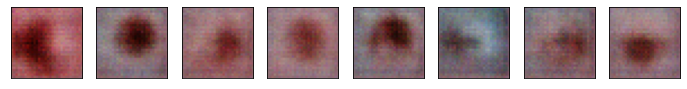

Epoch: 2, Iteration: 11, Labelled Loss: 0.126
Epoch: 2, Iteration: 11, Gen Loss: 1.702, Gen Accuracy: 0.039, DReal loss: 0.989, DReal accuracy: 0.461, DFake loss: 0.086, DFake accuracy: 1.000
Epoch: 2, Iteration: 12, Labelled Loss: 0.341
Epoch: 2, Iteration: 12, Gen Loss: 2.562, Gen Accuracy: 0.000, DReal loss: 0.124, DReal accuracy: 0.984, DFake loss: 0.692, DFake accuracy: 0.680
Epoch: 2, Iteration: 13, Labelled Loss: 0.325
Epoch: 2, Iteration: 13, Gen Loss: 1.998, Gen Accuracy: 0.062, DReal loss: 0.405, DReal accuracy: 0.828, DFake loss: 0.112, DFake accuracy: 1.000
Epoch: 2, Iteration: 14, Labelled Loss: 0.315
Epoch: 2, Iteration: 14, Gen Loss: 2.284, Gen Accuracy: 0.016, DReal loss: 0.202, DReal accuracy: 0.961, DFake loss: 0.417, DFake accuracy: 0.844
Epoch: 2, Iteration: 15, Labelled Loss: 0.386
Epoch: 2, Iteration: 15, Gen Loss: 2.208, Gen Accuracy: 0.031, DReal loss: 0.276, DReal accuracy: 0.938, DFake loss: 0.265, DFake accuracy: 0.953
Epoch: 2, Iteration: 16, Labelled Loss: 

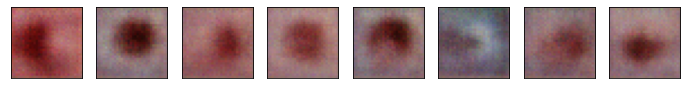

Epoch: 2, Iteration: 31, Labelled Loss: 0.038
Epoch: 2, Iteration: 31, Gen Loss: 1.392, Gen Accuracy: 0.156, DReal loss: 1.440, DReal accuracy: 0.195, DFake loss: 0.031, DFake accuracy: 1.000
Epoch: 2, Iteration: 32, Labelled Loss: 0.208
Epoch: 2, Iteration: 32, Gen Loss: 2.604, Gen Accuracy: 0.000, DReal loss: 0.049, DReal accuracy: 1.000, DFake loss: 1.227, DFake accuracy: 0.219
Epoch: 2, Iteration: 33, Labelled Loss: 0.486
Epoch: 2, Iteration: 33, Gen Loss: 1.102, Gen Accuracy: 0.227, DReal loss: 1.647, DReal accuracy: 0.102, DFake loss: 0.059, DFake accuracy: 1.000
Epoch: 2, Iteration: 34, Labelled Loss: 0.287
Epoch: 2, Iteration: 34, Gen Loss: 2.354, Gen Accuracy: 0.000, DReal loss: 0.050, DReal accuracy: 1.000, DFake loss: 1.222, DFake accuracy: 0.156
Epoch: 2, Iteration: 35, Labelled Loss: 0.221
Epoch: 2, Iteration: 35, Gen Loss: 1.229, Gen Accuracy: 0.250, DReal loss: 0.885, DReal accuracy: 0.516, DFake loss: 0.102, DFake accuracy: 1.000
Epoch: 2, Iteration: 36, Labelled Loss: 

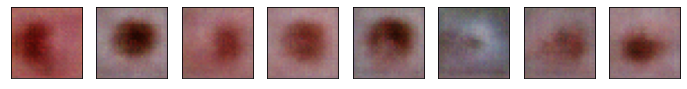

Epoch: 2, Iteration: 51, Labelled Loss: 0.773
Epoch: 2, Iteration: 51, Gen Loss: 1.306, Gen Accuracy: 0.156, DReal loss: 1.133, DReal accuracy: 0.227, DFake loss: 0.047, DFake accuracy: 1.000
Epoch: 2, Iteration: 52, Labelled Loss: 0.295
Epoch: 2, Iteration: 52, Gen Loss: 1.953, Gen Accuracy: 0.047, DReal loss: 0.105, DReal accuracy: 1.000, DFake loss: 1.059, DFake accuracy: 0.383
Epoch: 2, Iteration: 53, Labelled Loss: 0.223
Epoch: 2, Iteration: 53, Gen Loss: 1.452, Gen Accuracy: 0.070, DReal loss: 0.783, DReal accuracy: 0.562, DFake loss: 0.182, DFake accuracy: 0.984
Epoch: 2, Iteration: 54, Labelled Loss: 0.377
Epoch: 2, Iteration: 54, Gen Loss: 2.257, Gen Accuracy: 0.009, DReal loss: 0.134, DReal accuracy: 1.000, DFake loss: 0.445, DFake accuracy: 0.858
End of epoc
Training accuracy in spotting fakes for epoc:  0.7321022727272727
Training accuracy in discriminating malignant/benign for epoc:  0.8553503787878788
Validation accuracy in discriminating malignant/benign for epoc:  0.783

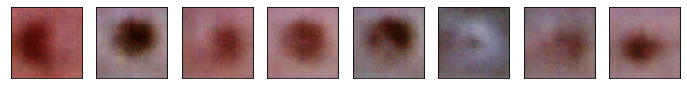

Epoch: 3, Iteration: 16, Labelled Loss: 0.673
Epoch: 3, Iteration: 16, Gen Loss: 2.234, Gen Accuracy: 0.008, DReal loss: 0.126, DReal accuracy: 1.000, DFake loss: 1.081, DFake accuracy: 0.469
Epoch: 3, Iteration: 17, Labelled Loss: 0.613
Epoch: 3, Iteration: 17, Gen Loss: 0.896, Gen Accuracy: 0.453, DReal loss: 1.207, DReal accuracy: 0.266, DFake loss: 0.138, DFake accuracy: 1.000
Epoch: 3, Iteration: 18, Labelled Loss: 0.119
Epoch: 3, Iteration: 18, Gen Loss: 2.574, Gen Accuracy: 0.000, DReal loss: 0.086, DReal accuracy: 1.000, DFake loss: 1.292, DFake accuracy: 0.180
Epoch: 3, Iteration: 19, Labelled Loss: 0.253
Epoch: 3, Iteration: 19, Gen Loss: 1.127, Gen Accuracy: 0.250, DReal loss: 1.433, DReal accuracy: 0.250, DFake loss: 0.118, DFake accuracy: 0.984
Epoch: 3, Iteration: 20, Labelled Loss: 0.224
Epoch: 3, Iteration: 20, Gen Loss: 1.954, Gen Accuracy: 0.023, DReal loss: 0.129, DReal accuracy: 0.977, DFake loss: 0.985, DFake accuracy: 0.445
Epoch: 3, Iteration: 21, Labelled Loss: 

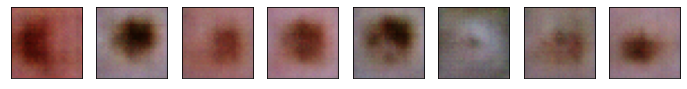

Epoch: 3, Iteration: 36, Labelled Loss: 0.283
Epoch: 3, Iteration: 36, Gen Loss: 2.328, Gen Accuracy: 0.016, DReal loss: 0.108, DReal accuracy: 1.000, DFake loss: 0.669, DFake accuracy: 0.656
Epoch: 3, Iteration: 37, Labelled Loss: 0.190
Epoch: 3, Iteration: 37, Gen Loss: 1.533, Gen Accuracy: 0.070, DReal loss: 0.454, DReal accuracy: 0.836, DFake loss: 0.118, DFake accuracy: 1.000
Epoch: 3, Iteration: 38, Labelled Loss: 0.220
Epoch: 3, Iteration: 38, Gen Loss: 2.628, Gen Accuracy: 0.000, DReal loss: 0.072, DReal accuracy: 1.000, DFake loss: 0.723, DFake accuracy: 0.523
Epoch: 3, Iteration: 39, Labelled Loss: 0.174
Epoch: 3, Iteration: 39, Gen Loss: 1.328, Gen Accuracy: 0.125, DReal loss: 0.893, DReal accuracy: 0.336, DFake loss: 0.043, DFake accuracy: 1.000
Epoch: 3, Iteration: 40, Labelled Loss: 0.524
Epoch: 3, Iteration: 40, Gen Loss: 2.943, Gen Accuracy: 0.008, DReal loss: 0.067, DReal accuracy: 1.000, DFake loss: 1.456, DFake accuracy: 0.219
Epoch: 3, Iteration: 41, Labelled Loss: 

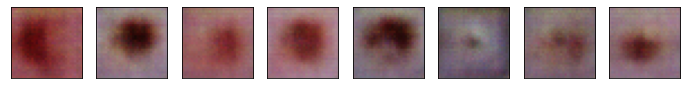

Epoch: 4, Iteration: 1, Labelled Loss: 0.648
Epoch: 4, Iteration: 1, Gen Loss: 1.689, Gen Accuracy: 0.055, DReal loss: 0.515, DReal accuracy: 0.758, DFake loss: 0.509, DFake accuracy: 0.727
Epoch: 4, Iteration: 2, Labelled Loss: 0.427
Epoch: 4, Iteration: 2, Gen Loss: 1.752, Gen Accuracy: 0.008, DReal loss: 0.553, DReal accuracy: 0.664, DFake loss: 0.493, DFake accuracy: 0.758
Epoch: 4, Iteration: 3, Labelled Loss: 0.251
Epoch: 4, Iteration: 3, Gen Loss: 2.202, Gen Accuracy: 0.008, DReal loss: 0.372, DReal accuracy: 0.852, DFake loss: 0.567, DFake accuracy: 0.664
Epoch: 4, Iteration: 4, Labelled Loss: 0.219
Epoch: 4, Iteration: 4, Gen Loss: 1.852, Gen Accuracy: 0.016, DReal loss: 0.534, DReal accuracy: 0.742, DFake loss: 0.154, DFake accuracy: 0.984
Epoch: 4, Iteration: 5, Labelled Loss: 0.111
Epoch: 4, Iteration: 5, Gen Loss: 2.857, Gen Accuracy: 0.000, DReal loss: 0.111, DReal accuracy: 1.000, DFake loss: 0.413, DFake accuracy: 0.859
Epoch: 4, Iteration: 6, Labelled Loss: 0.237
Epoch

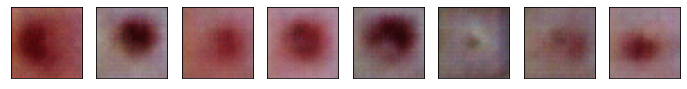

Epoch: 4, Iteration: 21, Labelled Loss: 0.192
Epoch: 4, Iteration: 21, Gen Loss: 1.529, Gen Accuracy: 0.047, DReal loss: 0.389, DReal accuracy: 0.875, DFake loss: 0.457, DFake accuracy: 0.844
Epoch: 4, Iteration: 22, Labelled Loss: 0.183
Epoch: 4, Iteration: 22, Gen Loss: 1.697, Gen Accuracy: 0.016, DReal loss: 0.393, DReal accuracy: 0.898, DFake loss: 0.365, DFake accuracy: 0.922
Epoch: 4, Iteration: 23, Labelled Loss: 0.498
Epoch: 4, Iteration: 23, Gen Loss: 1.690, Gen Accuracy: 0.086, DReal loss: 0.431, DReal accuracy: 0.805, DFake loss: 0.446, DFake accuracy: 0.773
Epoch: 4, Iteration: 24, Labelled Loss: 0.262
Epoch: 4, Iteration: 24, Gen Loss: 1.638, Gen Accuracy: 0.023, DReal loss: 0.545, DReal accuracy: 0.680, DFake loss: 0.304, DFake accuracy: 0.891
Epoch: 4, Iteration: 25, Labelled Loss: 0.564
Epoch: 4, Iteration: 25, Gen Loss: 1.645, Gen Accuracy: 0.023, DReal loss: 0.354, DReal accuracy: 0.852, DFake loss: 0.503, DFake accuracy: 0.703
Epoch: 4, Iteration: 26, Labelled Loss: 

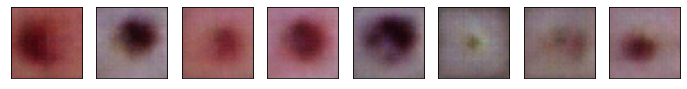

Epoch: 4, Iteration: 41, Labelled Loss: 0.202
Epoch: 4, Iteration: 41, Gen Loss: 1.617, Gen Accuracy: 0.023, DReal loss: 0.195, DReal accuracy: 0.992, DFake loss: 0.868, DFake accuracy: 0.438
Epoch: 4, Iteration: 42, Labelled Loss: 0.177
Epoch: 4, Iteration: 42, Gen Loss: 1.043, Gen Accuracy: 0.219, DReal loss: 0.835, DReal accuracy: 0.391, DFake loss: 0.194, DFake accuracy: 0.992
Epoch: 4, Iteration: 43, Labelled Loss: 0.228
Epoch: 4, Iteration: 43, Gen Loss: 1.589, Gen Accuracy: 0.000, DReal loss: 0.272, DReal accuracy: 0.930, DFake loss: 0.724, DFake accuracy: 0.500
Epoch: 4, Iteration: 44, Labelled Loss: 0.182
Epoch: 4, Iteration: 44, Gen Loss: 0.936, Gen Accuracy: 0.242, DReal loss: 0.769, DReal accuracy: 0.445, DFake loss: 0.359, DFake accuracy: 0.891
Epoch: 4, Iteration: 45, Labelled Loss: 0.197
Epoch: 4, Iteration: 45, Gen Loss: 1.872, Gen Accuracy: 0.008, DReal loss: 0.245, DReal accuracy: 0.961, DFake loss: 0.513, DFake accuracy: 0.812
Epoch: 4, Iteration: 46, Labelled Loss: 

In [26]:
run_model(2)

Picking the number of epochs to maximize the validation accuracy gives a test accuracy of around 76%.

## Final thoughts

Switching from a CNN to a SGAN and making use of the additional unlabelled data has resulted in an increase in test accuracy from 71% to 76%. Even allowing for the effects of hyperparameters and the stochastic nature of the models, I believe this is definitely an improvement in performance. I had expected a larger improvement in accuracy, but believe the improvement was relatively modest due to the unexpectedly high performance of the supervised CNN. 

Both SGANs and transfer learning (which gave 78% accuracy) are clearly key techniques for getting better performance out of deep neural networks where there is insufficient data - i.e. most real world scenarios.

One final point. The test accuracy is a very simple measure of the performance of the model. A better metric would be AUC-ROC, which is measures how well the model trades off specificy and sensitivity.